### Link below provides the dataset for this task,
### https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
from numpy.random import seed
import tensorflow as tf
from keras import backend

# glob module to read all files from a directory
import glob

In [ ]:
print("available gpus: ", len(tf.config.experimental.list_physical_devices("GPU")))

available gpus:  1


In [ ]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(device_count={"GPU":1, "CPU":2}))
backend.set_session(sess)
# set keras session to be able to run gpu

In [ ]:
seed(7)
random.seed(7)
base_path = "/content/drive/MyDrive/pneumonia_classification/"

# reading dataset
train_normal_path = glob.glob(base_path + "train/NORMAL/*.jpeg")
train_pneumonia_path = glob.glob(base_path + "train/PNEUMONIA/*.jpeg")
test_normal_path = glob.glob(base_path + "test/NORMAL/*.jpeg")
test_pneumonia_path = glob.glob(base_path + "test/PNEUMONIA/*.jpeg")


In [ ]:
len(test_normal_path), len(test_pneumonia_path)

(234, 390)

In [ ]:
train_percentage = len(train_normal_path)/(len(train_normal_path) + len(train_pneumonia_path))
test_percentage = len(test_normal_path)/(len(test_normal_path) + len(test_pneumonia_path))
print(100 * test_percentage, 100 * train_percentage)

37.5 25.7737867787543


glob.glob returns a list of strings that include all the paths. We can see that there is a bit of unbalance in the dataset. Can't be sure but it should not be much of a problem for now.

In [ ]:
train_paths = [i for i in train_normal_path]
train_paths.extend([j for j in train_pneumonia_path])

test_paths = [i for i in test_normal_path]
test_paths.extend([j for j in test_pneumonia_path])
# constructing a list for all train paths, we can just read from the paths with the flow_from_dataframe method of ImageDataGenerator

train_df = pd.DataFrame(np.concatenate([['normal'] * len(train_normal_path) , ['pneumonia'] * len(train_pneumonia_path)]), columns = ['class'])
test_df = pd.DataFrame(np.concatenate([['normal'] * len(test_normal_path) , ['pneumonia'] * len(test_pneumonia_path)]), columns = ['class'])

train_df['images'] = [i for i in train_paths]
test_df['images'] = [i for i in test_paths]

pneumonia samples


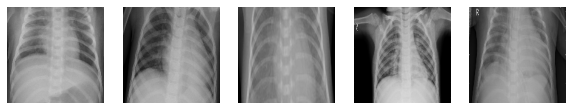

normal samples


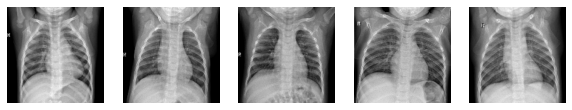

In [ ]:
def show_sample(how_many: int, is_infected: bool):
    plt.figure(figsize=(10, 10))
    print("pneumonia samples" if is_infected else "normal samples")
    for i in range(0, how_many):
        plt.subplot(3, how_many, i + 1)
        if is_infected:
            img = cv2.imread(train_pneumonia_path[i])
        else:
            img = cv2.imread(train_normal_path[i])
        img = cv2.resize(img, (160, 160))
        plt.imshow(img)
        plt.axis("off")

    plt.show()

show_sample(5, True)
show_sample(5, False)

We can observe the differences between normal and infected people. Pneumonia samples tend to show intensity around the lung area. Which is not expected as we want to see more hollow-like feature from the air that is contained in the lungs. 

In [ ]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
# Image data generator can resize and has a method that allows it to load from the dataframe

SIZE = 224  # 224 for resnet152v2
batch_size = 64

train_set, val_set = train_test_split(train_df, test_size=0.15)
# around 800 samples for val_set

In [ ]:
train_process = ImageDataGenerator(rescale=1/255.0,
                                   zoom_range = 0.1,
                                   rotation_range = 0.1,
                                   )
test_process = ImageDataGenerator(rescale=1/255.0)

train = train_process.flow_from_dataframe(train_set, x_col = 'images', y_col = 'class',
                                          target_size = (SIZE, SIZE), class_mode = 'binary',
                                          batch_size = batch_size, seed=7)
val = test_process.flow_from_dataframe(val_set, x_col = 'images', y_col = 'class',
                                          target_size = (SIZE, SIZE), class_mode = 'binary',
                                          batch_size = batch_size, seed=7)
test = test_process.flow_from_dataframe(test_df, x_col = 'images', y_col = 'class',
                                          target_size = (SIZE, SIZE), class_mode = 'binary',
                                          batch_size = batch_size, shuffle=False)


Found 4448 validated image filenames belonging to 2 classes.
Found 786 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [ ]:
from keras.applications.resnet_v2 import ResNet152V2
from keras import layers, Model, callbacks
# importing necessary model and functions

In [ ]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=4,
    min_delta=1e-7,
    restore_best_weights=True,
)

# to change lr when the val_loss seems to be stuck at an area
plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.4,
    patience = 3,
    min_delt = 1e-6,                                
    cooldown = 0,
    verbose = 1  # to monitor
)

def schedule(epoch: int, lr: float) -> float:
    return lr if epoch==1 else lr*0.9

lrscheduler = callbacks.LearningRateScheduler(schedule, verbose=1)  
# accuracy responds very quickly with the changes in the lr so I scheduled it to lower every epoch. 

In [ ]:
def get_model():
    base_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(SIZE, SIZE, 3),
    include_top=False)

    base_model.trainable = True

    # making some layers trainable
    for layer in base_model.layers[:-20]:
        layer.trainable = False
        
    inputs = layers.Input(shape=(SIZE, SIZE, 3))
    
    x = base_model(inputs)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=inputs, outputs=out)
    # model is just the resnet152v2 model and 2 dense layers enveloped in one. this is enough for it to give decent accuracy

    return model

In [ ]:
from keras.losses import BinaryCrossentropy
from tensorflow import keras
from keras.metrics import BinaryAccuracy
from keras.backend import clear_session
from keras.optimizer_v1 import Adam

tf.compat.v1.disable_eager_execution()
clear_session()

model = get_model()
model.compile(
    loss=BinaryCrossentropy(),
    optimizer=Adam(lr=2e-5, amsgrad=True),  # amsgrad is a version for adam which prevents abrupt changes in lr.
    metrics=[BinaryAccuracy()]
)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [ ]:
hist = model.fit(train,
                 epochs=10,
                 validation_data=val,
                 callbacks=[lrscheduler, early_stopping, plateau]
                 )



Epoch 1: LearningRateScheduler setting learning rate to 1.7999999545281754e-05.
Epoch 1/10
70/70 [==============================] - ETA: 0s - batch: 34.5000 - size: 63.5429 - loss: 0.3724 - binary_accuracy: 0.8629

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


70/70 [==============================] - 150s 2s/step - batch: 34.5000 - size: 63.5429 - loss: 0.3724 - binary_accuracy: 0.8629 - val_loss: 0.2107 - val_binary_accuracy: 0.9097 - lr: 1.8000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.799999881768599e-05.
Epoch 2/10
70/70 [==============================] - 135s 2s/step - batch: 34.5000 - size: 63.5429 - loss: 0.1820 - binary_accuracy: 0.9362 - val_loss: 0.1908 - val_binary_accuracy: 0.9402 - lr: 1.8000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.6199998935917392e-05.
Epoch 3/10
70/70 [==============================] - 136s 2s/step - batch: 34.5000 - size: 63.5429 - loss: 0.1284 - binary_accuracy: 0.9584 - val_loss: 0.1119 - val_binary_accuracy: 0.9644 - lr: 1.6200e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.457999969716184e-05.
Epoch 4/10
70/70 [==============================] - 137s 2s/step - batch: 34.5000 - size: 63.5429 - loss: 0.1056 - binary_accuracy: 0.9652 - val_loss: 0.09

In [ ]:
from sklearn.metrics import accuracy_score

predictions = model.predict(test)
yhat = np.where(predictions>0.92, 1, 0)


In [ ]:
accuracy_score(test.classes, yhat)

0.9423076923076923

In [ ]:
from sklearn import metrics

print(metrics.classification_report(test.classes, yhat))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92       234
           1       0.97      0.94      0.95       390

    accuracy                           0.94       624
   macro avg       0.94      0.94      0.94       624
weighted avg       0.94      0.94      0.94       624



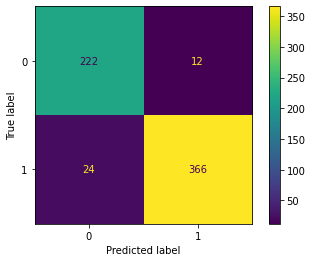

In [ ]:
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(test.classes, yhat)).plot()

In here I chose the threshold in order to obtain better accuracy but it increased the number of false positives. A case could be to combine multiple models that outputs low number false positives or low number of true negatives.

A better outcome can be achieved through a research on what is the most necessary factor for pneumia detection and what is the minimum human error rate.


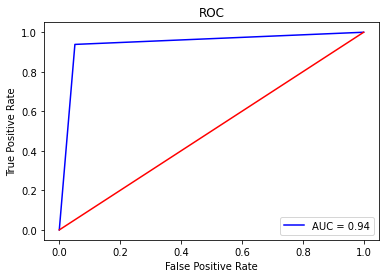

In [ ]:
fpr, tpr, threshold = metrics.roc_curve(test.classes, yhat)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'best')
plt.plot([0, 1], [0, 1],'r')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
from keras.models import save_model

save_model(model=model, filepath="/content/drive/MyDrive/pneumonia_classification/")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/pneumonia_classification/assets
